In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
train = pd.read_csv('hm_train.csv')
train.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection


In [2]:
train['predicted_category'].unique()

array(['affection', 'exercise', 'bonding', 'leisure', 'achievement',
       'enjoy_the_moment', 'nature'], dtype=object)

In [3]:
from tensorflow.keras import metrics

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from tensorflow.keras.utils.np_utils import to_categorical

In [5]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100


text_clean = train['cleaned_hm'].values

In [6]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_clean)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21567 unique tokens.


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encode = LabelEncoder().fit(train['predicted_category'])
Y = label_encode.transform(train['predicted_category'])
Y = Y.reshape(-1,1)
# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(text_clean)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

Shape of data tensor: (60321, 50)


In [45]:
len(X[0])

50

Shape of data tensor: (60321, 50)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_7 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_8 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 147       
Total params: 2,252,017
Trainable params: 2,252,017
Non-trainable params: 0
__________

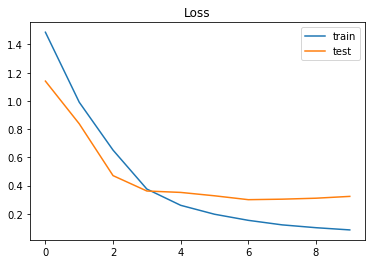

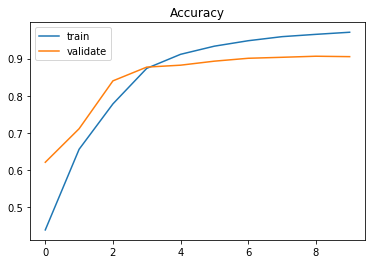

In [22]:
from sklearn.model_selection import train_test_split
# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(text_clean)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

# Define LSTM Model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Training LSTM Model
epochs = 10
batch_size = 500
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,Y_test))


plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validate')
plt.legend()
plt.show();

In [26]:
history.set_params

<bound method Callback.set_params of <tensorflow.python.keras.callbacks.History object at 0x00000175079D2508>>

In [29]:
score = model.evaluate(X_test,Y_test)
print("Loss:{0}".format(score[0]))
print("accuracy:{0}".format(score[1]))

Loss:0.3231991992791681
accuracy:0.9051787257194519


In [30]:
test = pd.read_csv('hm_test.csv')
test.head()

,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,3m,I spent the weekend in Chicago with my friends.,1
1,88306,3m,We moved back into our house after a remodel. ...,2
2,88307,3m,My fiance proposed to me in front of my family...,1
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1
4,88309,3m,I went out to a nice restaurant on a date with...,5


In [31]:
X = tokenizer.texts_to_sequences(test['cleaned_hm'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
y_probas = model.predict(X)
y_pred = np.argmax(y_probas, axis=1)

In [33]:
len(y_pred)

40213

In [34]:
y_pred.shape

(40213,)

In [35]:
train['predicted_category'].shape

(60321,)

In [36]:
predicted_category = label_encode.inverse_transform(y_pred)
pd.Series(predicted_category).unique()

array(['bonding', 'achievement', 'affection', 'leisure',
       'enjoy_the_moment', 'exercise', 'nature'], dtype=object)

In [37]:
predicted_category

array(['bonding', 'achievement', 'affection', ..., 'affection',
       'achievement', 'exercise'], dtype=object)

In [38]:
test['predicted_category']=predicted_category

In [39]:
test['cleaned_hm'][4]

'I went out to a nice restaurant on a date with my wife. It was a very popular restaurant and we could not get a reservation. But I have a friend who owns a famous hamburger place next door to this restaurant. He was able to get us a table! We had a great table, great service, great food, and they even comped most of our dinner, so we paid almost nothing! '

In [40]:
my_dict = {'hmid':test['hmid'],'predicted_category':test['predicted_category']}

In [41]:
file = pd.DataFrame(my_dict,columns=['hmid','predicted_category'])
file.head()

,hmid,predicted_category
0,88305,bonding
1,88306,achievement
2,88307,affection
3,88308,bonding
4,88309,bonding


In [43]:
file.to_csv("hm_test_pred.csv",index= False)

In [ ]:
# save the model
model.save('model_LSTM.h5')